<a href="https://colab.research.google.com/github/akalpit23/Interpretable-ML/blob/main/Assignment-4/Assignment_04_Interpretable_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04



## Akalpit Dawkhar

### **Interpretable ML-2**

### Overview

# 1. Importing neccesarry libraries, loading and preprocessing the data. 

In [257]:
!pip install attrs packaging editables pandas scikit-learn sortedcontainers gmpy2 matplotlib
!pip install gosdt

/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.6/696.6 kB 7.2 MB/s eta 0:00:00


/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement gosdt (from versions: none)
ERROR: No matching distribution found for gosdt


In [93]:
!pip install collections
!pip show imodels

/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Name: imodels
Version: 1.4.6
Summary: Implementations of various interpretable models
Home-page: https://github.com/csinva/imodels
Author: Chandan Singh, Keyan Nasseri, Matthew Epland, Yan Shuo Tan, Omer Ronen, Tiffany Tang, Abhineet Agarwal, Theo Saarinen, Bin Yu, and others
Author-email: chandan_singh@berkeley.edu
License: 
Location: /Users/akalpitdawkhar/Desktop/School/SEM 3/XAI/Interpretable-ML/xai/lib/python3.12/site-packages
Requires: matplotlib, mlxtend, numpy, pandas, requests, scikit-learn, scipy, tqdm
Required-by: 


In [241]:
!pip install skope-rules shap lime scikit-learn seaborn skope-rules matplotlib setuptools six rulefit --upgrade
!pip install --upgrade imodels


/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=85550) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import sklearn
import collections
import demo_helper
import six
import os
collections.Iterable = collections.abc.Iterable
sklearn.externals.six = six
from scipy.io import arff
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler ,OneHotEncoder, label_binarize, KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve, roc_auc_score
from sklearn.datasets import load_diabetes
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from itertools import cycle
import skrules.skope_rules
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import six
from imodels import  RuleFitRegressor, BoostedRulesClassifier, GreedyRuleListClassifier, GreedyTreeClassifier, GreedyTreeRegressor, OneRClassifier , HSTreeClassifierCV
from rulefit import RuleFit
from skrules import SkopeRules
from skrules import SkopeRules as SkopeRulesClassifier

In [96]:
def patched_init(*args, **kwargs):
     """
    Patched __init__ method for BaggingClassifier in the skrules.skope_rules module.

    This patch modifies the constructor (__init__) of the BaggingClassifier class to ensure
    compatibility with updated scikit-learn or model APIs. Specifically, it renames the 
    'base_estimator' argument to 'estimator', as some versions of libraries may expect 
    'estimator' instead of 'base_estimator'.

    Parameters:
    *args: tuple
        Positional arguments that are passed to the original __init__ method of 
        BaggingClassifier.

    **kwargs: dict
        Keyword arguments that are passed to the original __init__ method of 
        BaggingClassifier. If 'base_estimator' is provided, it is renamed to 'estimator'
        before passing to the original __init__ method.

    Returns:
    object
        The initialized BaggingClassifier object after calling the original __init__ 
        with modified arguments, if applicable.

    Notes:
    ------
    This patch is useful for maintaining backward compatibility with older versions of 
    code or when there is a naming conflict in the API. It modifies the constructor at 
    runtime without directly altering the source code of the `imodels` or `skrules` library.
    """
    if 'base_estimator' in kwargs:
        kwargs['estimator'] = kwargs.pop('base_estimator')
    return original_init(*args, **kwargs)

original_init = skrules.skope_rules.BaggingClassifier.__init__
skrules.skope_rules.BaggingClassifier.__init__ = patched_init

In [97]:
def patch_estimator(cls):
    """
    Patched initialization method for BaggingClassifier in the skrules.skope_rules module.

    This function modifies the '__init__' method of the BaggingClassifier class to replace 
    the 'base_estimator' keyword argument with 'estimator' to maintain compatibility 
    with updated API changes or requirements in the 'skrules.skope_rules' package.

    Parameters:
    *args: tuple
        Positional arguments passed to the original __init__ method of BaggingClassifier.
        
    **kwargs: dict
        Keyword arguments passed to the original __init__ method of BaggingClassifier.
        If 'base_estimator' is present in the kwargs, it is replaced with 'estimator'.

    Returns:
    The result of calling the original __init__ method of BaggingClassifier with modified 
    arguments and keyword arguments.
    
    Notes:
    This patch is necessary because some versions of scikit-learn and other model 
    implementations may use 'estimator' instead of 'base_estimator'. This ensures 
    compatibility without modifying the underlying library directly.
    """
    original_init = cls.__init__
    def patched_init(*args, **kwargs):
        if 'base_estimator' in kwargs:
            kwargs['estimator'] = kwargs.pop('base_estimator')
        return original_init(*args, **kwargs)
    cls.__init__ = patched_init

patch_estimator(skrules.skope_rules.BaggingClassifier)
patch_estimator(skrules.skope_rules.BaggingRegressor)

In [214]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Convert the continuous target to binary
y_median = np.median(diabetes.target)
y = (diabetes.target > y_median).astype(int)  # labels 0-1

# Prepare the feature data
X = diabetes.data.astype('float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split


In [194]:
# Convert to DataFrame
diabetes_df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

# Print the first 5 rows
print(diabetes_df.head())

# Get the feature names
f_names = diabetes.feature_names

f_names

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [219]:
# Check the shape of your DataFrame
print(X_train.shape)

# Check the column names of your DataFrame
print(diabetes_df.columns)

(110, 10)
Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')


# 2. RuleFit rule sit 

In [220]:
# Initialize the RuleFitRegressor
rf = RuleFitRegressor(max_rules=10, memory_par=0.01, tree_size=4, lin_standardise=True)

# Fit the model to your data
rf.fit(X_train, y_train)

RuleFitRegressor(max_rules=10)

In [221]:
# Use the model to make predictions
predictions = rf.predict(X_test)

In [222]:
rule_df = rf.visualize()
rule_df

,rule,coef
14,X2 > -0.038 and X6 <= 0.03023,0.02
12,X3 > -0.07108 and X8 <= -0.00422,-0.04
11,X2 <= 0.01589 and X4 > -0.05248 and X8 <= 0.022,-0.08
16,X6 <= 0.05416 and X8 > -0.01395,0.04
19,X2 > -0.03207 and X3 > -0.05903 and X6 <= 0.02103,0.00
13,X0 <= 0.08348 and X0 > -0.02186 and X8 <= 0.0137,-0.04
15,X3 > -0.01543 and X6 <= 0.05784 and X9 > -0.04871,0.13
17,X3 > -0.01543 and X6 <= 0.05784 and X8 > -0.01501,0.19
10,X1 > 0.00302 and X2 <= 0.01912 and X8 <= 0.02831 and X9 <= 0.05277,-0.00
18,X6 <= 0.02839 and X8 > 0.0137 and X9 > -0.03421,0.01


In [238]:
# Inspect and print the rules
print('Rulefit visualization:')
rules = rf._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='Blues'))

Rulefit visualization:


,rule,coef,support
14,X2 > -0.038 and X6 <= 0.03023,0.023484,0.618182
12,X3 > -0.07108 and X8 <= -0.00422,-0.038623,0.527273
11,X2 <= 0.01589 and X4 > -0.05248 and X8 <= 0.022,-0.076746,0.500000
16,X6 <= 0.05416 and X8 > -0.01395,0.041131,0.472727
19,X2 > -0.03207 and X3 > -0.05903 and X6 <= 0.02103,0.004285,0.463636
13,X0 <= 0.08348 and X0 > -0.02186 and X8 <= 0.0137,-0.036850,0.436364
15,X3 > -0.01543 and X6 <= 0.05784 and X9 > -0.04871,0.126797,0.436364
17,X3 > -0.01543 and X6 <= 0.05784 and X8 > -0.01501,0.187707,0.327273
10,X1 > 0.00302 and X2 <= 0.01912 and X8 <= 0.02831 and X9 <= 0.05277,-0.000370,0.300000
18,X6 <= 0.02839 and X8 > 0.0137 and X9 > -0.03421,0.008890,0.245455


In [239]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)

# Calculate the R-squared score
r2 = r2_score(y_test, predictions)

# Print the metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MAE: 0.41051141012143705
MSE: 0.20199137538069345
R2 Score: 0.19015359522910102


# 3. Greedy Rule List Classifier 

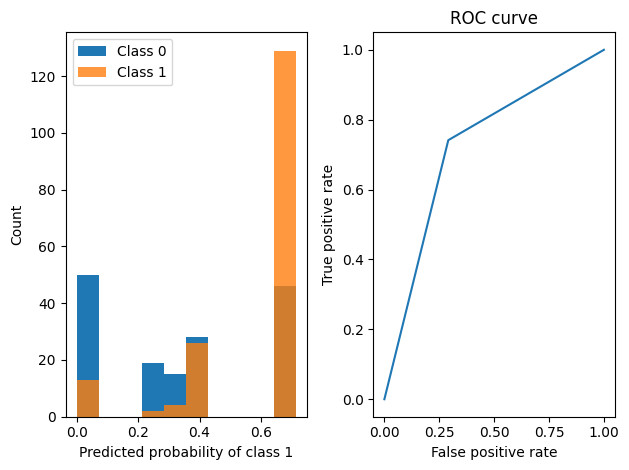

GreedyRuleListClassifier()

In [240]:
# fit a greedy rule list
greedy_model = GreedyRuleListClassifier()
greedy_model.fit(X_train, y=y_train, feature_names=f_names)  # stores into m.rules_
probability_grlc = greedy_model.predict_proba(X_test)

# look at prediction breakdown
demo_helper.viz_classification_preds(probability_grlc, y_test)

m

# 4. Boosted Rules Classifier

In [233]:
# Initialize and train BoostedRulesClassifier
boosted_model = BoostedRulesClassifier()
boosted_model.fit(X_train, y_train)
y_pred_boosted = boosted_model.predict_proba(X_test)
accuracy_boosted = accuracy_score(y_test, y_pred_boosted)
print(f"BoostedRulesClassifier Accuracy: {accuracy_boosted}")

/Users/akalpitdawkhar/Desktop/School/SEM 3/XAI/Interpretable-ML/xai/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [205]:
# Use the model to make predictions
predictions_brc= boosted_model.predict(X_test)

# 5. Greedy Tree Regressor 

In [206]:
gtr_model = GreedyTreeRegressor()  # or GreedyTreeRegressor() for regression tasks
gtr_model.fit(X_train, y_train)
accuracy_greedytree = accuracy_score(y_test, y_pred_boosted)
print(f"GreedyTreeRegressor: {accuracy_greedytree}")

GreedyTreeRegressor: 0.0


In [207]:
# Use the model to make predictions
predictions_gtc = gtr_model.predict(X_test)

# 6. Refrences:


In [252]:
# Initialize SkopeRules
clf = SkopeRules(max_depth_duplication=1,
                 n_estimators=30,
                 precision_min=0.2,
                 recall_min=0.01,
                 feature_names=f_names)

# Fit the model to your data
clf.fit(X_train, y_train)
y_score = clf.score_top_rules(X_test) # Get a risk score for each test example
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.show()

RecursionError: maximum recursion depth exceeded